# Ex.1 - Experimenting with Multi-Class Sequence Classification using RNNs and LSTMs

In [ ]:
'''
Experimenting with Multi-Class Sequence Classification using RNNs and LSTMs
Steps :
1. Load and visualize the training and testing data in 'data/P2_E1.csv' as shown in the following code cell.
2. Following section 2 in the examples, train a RNN or LSTM to solve the multi-class sequence classification problem:
  -   Adapt the classification loss and the SequenceClassifier module
  -   Adapt the test_sequence_classifier function to compute the multi-class accuracy and be able to visualize the confusion matrix
3. Experiment with different models by changing different hyper-parameters (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate  the results for each of them on the testing set.
4. Visualize analyse and discuss the results in the report.
'''

"\nExperimenting with Multi-Class Sequence Classification using RNNs and LSTMs\nSteps :\n1. Load and visualize the training and testing data in 'data/P2_E1.csv' as shown in the following code cell.\n2. Following section 2 in the examples, train a RNN or LSTM to solve the multi-class sequence classification problem:\n  -   Adapt the classification loss and the SequenceClassifier module\n  -   Adapt the test_sequence_classifier function to compute the multi-class accuracy and be able to visualize the confusion matrix\n3. Experiment with different models by changing different hyper-parameters (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate  the results for each of them on the testing set.\n4. Visualize analyse and discuss the results in the report.\n"

#Sol 1.

Mounted at /content/drive
Train Seqs: (210, 40)
Train Labels: (210,)
Test Seqs: (90, 40)
Test Labels: (90,)


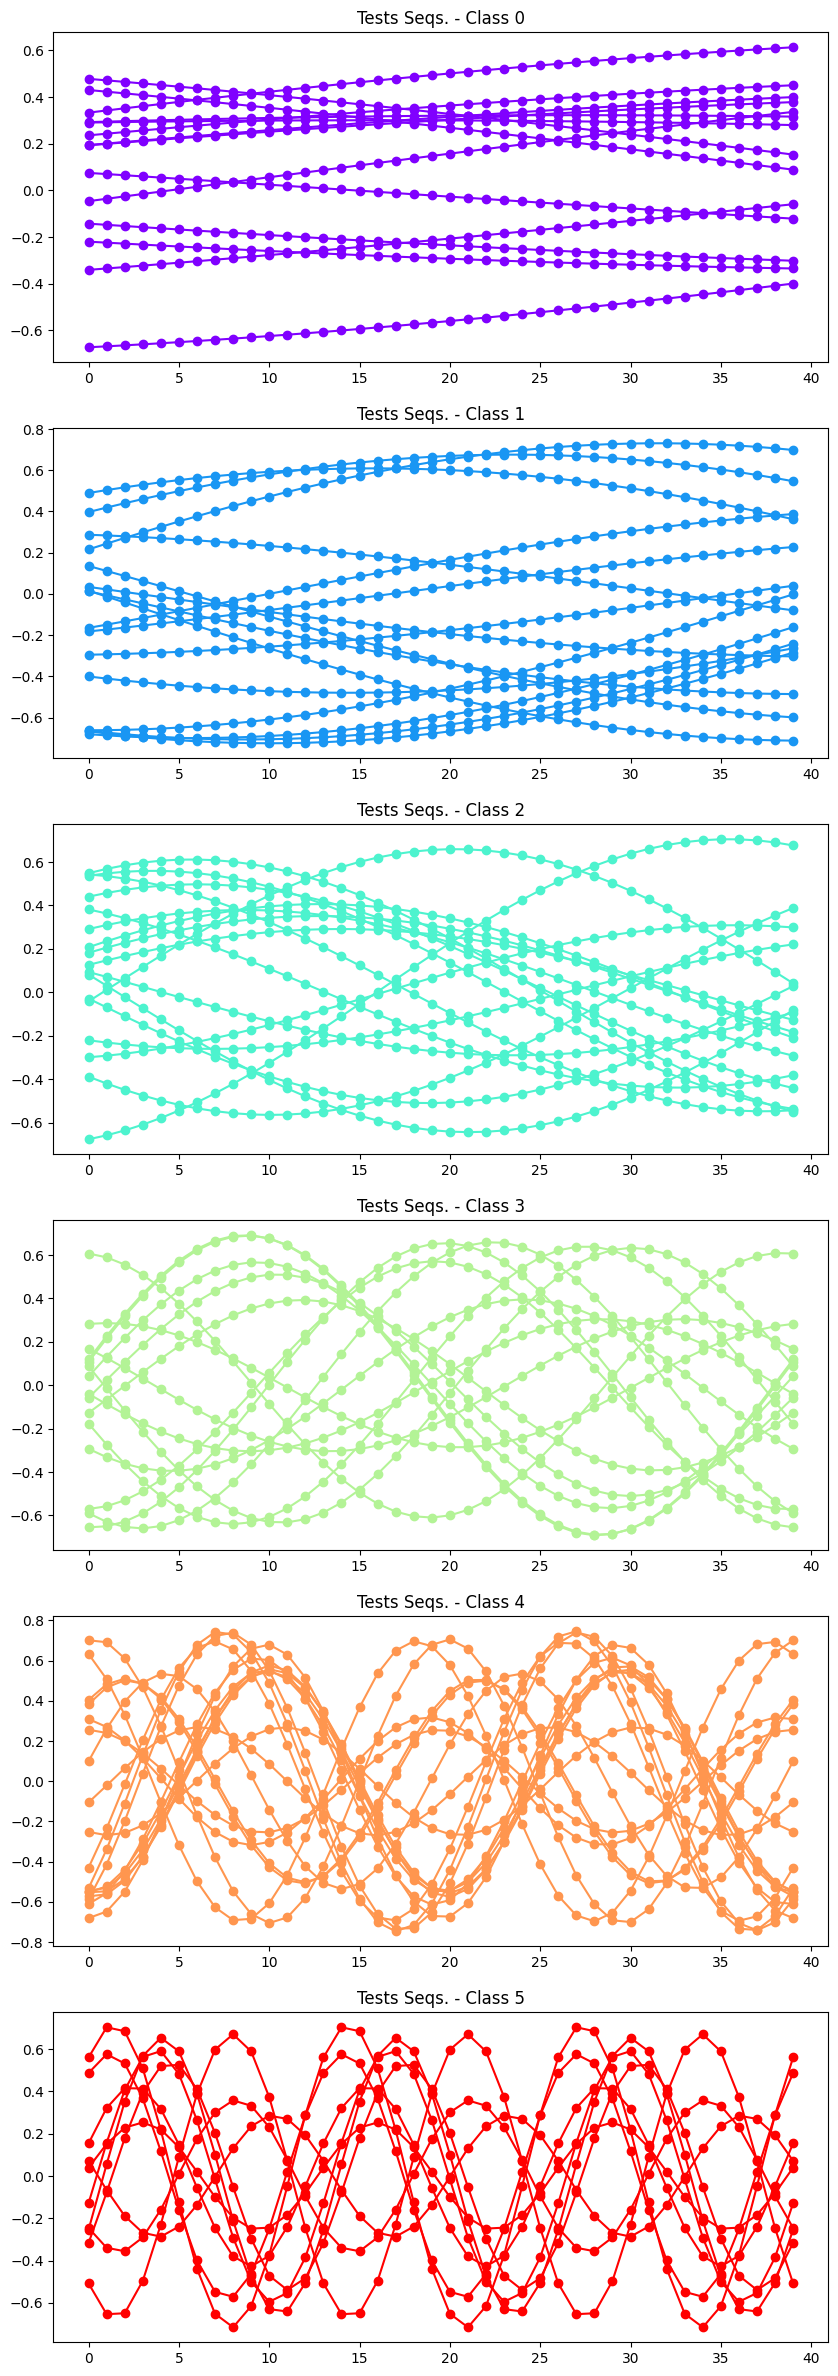

In [ ]:
from google.colab import drive
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

drive.mount('/content/drive')
myDrive = '/content/drive/Shareddrives/Deep_Learning_2024/P2/Data/'


file_path = os.path.join(myDrive,'P2_E1.npz')
data = np.load(file_path )
X_train, X_test = data['X_train'],data['X_test']
Y_train, Y_test = data['Y_train'],data['Y_test']

print(f'Train Seqs: {X_train.shape}')
print(f'Train Labels: {Y_train.shape}')
print(f'Test Seqs: {X_test.shape}')
print(f'Test Labels: {Y_test.shape}')

classes = np.unique(Y_train)
n_classes = len(classes)
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

fig, axs = plt.subplots(n_classes,1, figsize=(10, 5*n_classes))
for class_idx in range(0,n_classes):
  axs[class_idx].plot(X_test[Y_test==class_idx,:].T,'-o',
                      c=colors[class_idx])
  axs[class_idx].set_title(f'Tests Seqs. - Class {class_idx}')
fig.show()


In [ ]:
from torch.nn.modules import activation
import torch
from torch import nn

# Define module encapsulating a Sequence Classifier using RNN or LSTMs and setting different architecture hyper-parameters
class SequenceClassifier(nn.Module):
  def __init__(self,
               input_size : int = 1,
               hidden_size : int = 5,
               num_layers = 5,
               use_lstm : bool = False,
               activation_function = nn.Softmax(dim = 1)):  #softmax activation function in order to get multiclass probability
    # Define RNN or LSTM architecture
    super().__init__()
    self.use_lstm = use_lstm
    if(use_lstm):
      self.rnn =  nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                          num_layers=num_layers, batch_first = True)
    else:
      self.rnn =  nn.RNN(input_size = input_size, hidden_size = hidden_size,
                         num_layers=num_layers, batch_first = True)
    self.activation_function = activation_function
    self.last_linear = nn.Linear(hidden_size,6)   # change so that the last layer has as many elements as number of classes

  def forward(self, X):
    _,last_states = self.rnn(X)
    # Get last hidden state for last layer. Ignore cell state in case of LSTMs
    if(not self.use_lstm):
      last_hidden_state = last_states[-1,:,:].squeeze(0)
    else:
      last_hidden_state = last_states[0][-1,:,:].squeeze(0)
    # Get sequence label probability using the last hidden state
    last_linear = self.last_linear(last_hidden_state)
    output = self.activation_function(last_linear)
    return output


In [ ]:
def train_sequence_classifier(X_train, Y_train, seq_classifier, optimizer, loss_func, epochs=100):
    loss_its = []
    for iter in range(epochs):
      optimizer.zero_grad()
      output = seq_classifier(X_train)
      loss = loss_func(output.log(),Y_train)
      loss_its.append(loss.item())
      loss.backward()
      optimizer.step()
    print(f'Final loss: {loss.item()}')
    return np.asarray(loss_its)

In [ ]:
# Compute accuracy accross testing dataset
def test_sequence_classifier(X_test, Y_test, seq_classifier, prob_threshold=0.5):
  labels = [0, 1, 2, 3, 4, 5]
  true_labels = []
  pred_labels = []
  output = seq_classifier(X_test)
  output_argmax = torch.argmax(output, dim = 1)
  true_labels.extend(Y_test.cpu().numpy())
  pred_labels.extend(output_argmax.cpu().numpy())

  #we have to compute confusion matrix, we use sklearn and sns
  num_classes = 6
  cm = confusion_matrix(true_labels, pred_labels)
  accuracy = (((output_argmax)==(Y_test))*1.0).mean()

  print(f'Test Accuracy: {accuracy.item()}')

  # Plot
  plt.figure(figsize=(8, 6))
  sns.set(font_scale=1.2)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.show()
  return accuracy.item()

Training: softmaxH5_NL2_LSTM0
Final loss: 1.1979488134384155
Test Accuracy: 0.3777777850627899


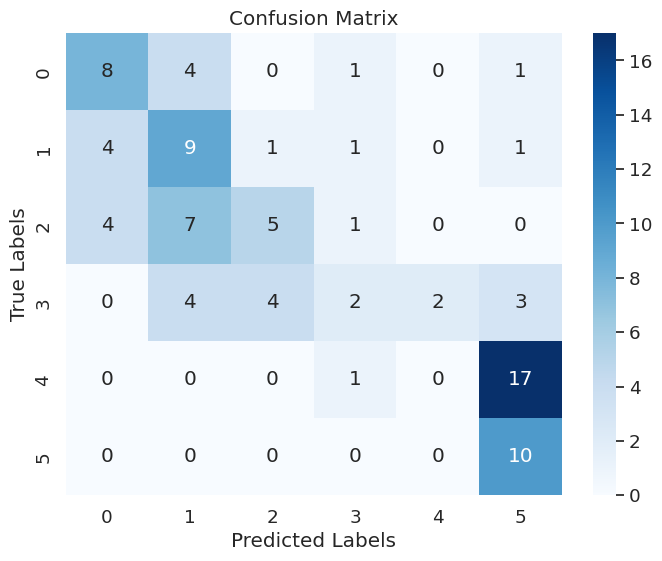

Training: softmaxH5_NL2_LSTM1
Final loss: 0.6974737048149109
Test Accuracy: 0.5777778029441833


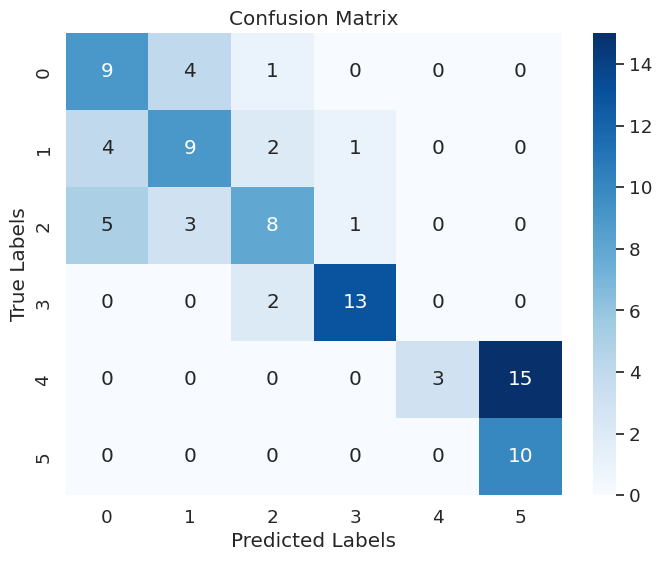

In [ ]:
# Dataset to PyTorch format

X_train_pt = torch.from_numpy(X_train).float().unsqueeze(2).cuda()
Y_train_pt = torch.from_numpy(Y_train).long().cuda()  #we changed the format as new loss function didn't accept float and unsqueezed
X_test_pt = torch.from_numpy(X_test).float().unsqueeze(2).cuda()
Y_test_pt = torch.from_numpy(Y_test).long().cuda()

# Define Binary Cross entr
loss_func = nn.CrossEntropyLoss() #set the loss function to cross entropy as it's good for multiclass

input_size = 1
exp_hidden_size = [1,3,5,8] # try different size for hidden layers
exp_num_layers = [1,2,3]  # try different num of layers
exp_use_lstm = [False,True]# try lstm vs vanilla RNN
exp_activation_functions = {    #try different activ ation functions
    'softmax': nn.Softmax(dim=1),
    'log_softmax': nn.LogSoftmax(dim=1),
    'relu': nn.ReLU(),
}
default_activation_functions = {    #try different activ ation functions
    'softmax': nn.Softmax(dim=1),
}
default_hidden_size = [5]
default_num_layers = [2]
default_use_lstm = [False, True]

losses_models = {}
test_accuracy_models = {}
for activation_name,activation_function in default_activation_functions.items():    #activation name in case we want to print which one we are using.
  for hidden_size in default_hidden_size:
    for num_layers in default_num_layers:
      for use_lstm in default_use_lstm:
        model_id = f'{activation_name}H{hidden_size}_NL{num_layers}_LSTM{int(use_lstm)}'
        print(f'Training: {model_id}')
        seq_classifier = SequenceClassifier(use_lstm=use_lstm,num_layers=num_layers,hidden_size=hidden_size)
        seq_classifier.cuda()
        optimizer = torch.optim.Adam(seq_classifier.parameters(), lr=1e-3)
        losses_models[model_id] = train_sequence_classifier(X_train_pt, Y_train_pt,
                                  seq_classifier, optimizer,
                                  loss_func, epochs=1000)
        test_accuracy_models[model_id]  = test_sequence_classifier(X_test_pt,Y_test_pt,seq_classifier)

plt subplots maybe

#Testing Several Modifications

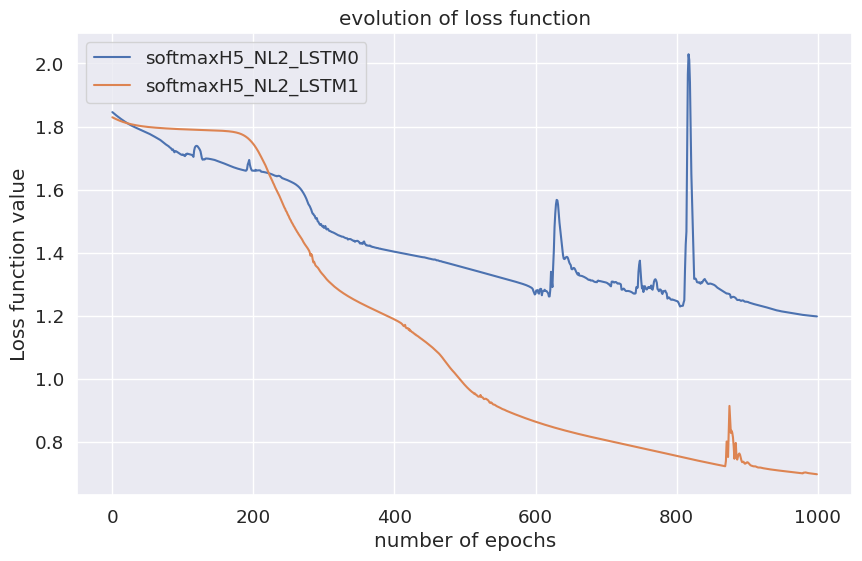

,softmaxH5_NL2_LSTM0,softmaxH5_NL2_LSTM1
accuracy %,37.777779,57.77778


In [ ]:

plt.figure(figsize=(10, 6))
for loss_it in losses_models.values():
  plt.plot(loss_it)
plt.legend(losses_models.keys())
plt.xlabel('number of epochs')
plt.ylabel('Loss function value')
plt.title('evolution of loss function')
plt.show()

pd.DataFrame(np.asarray(list(test_accuracy_models.values()))*100, columns=['accuracy %'],
             index=test_accuracy_models.keys()).transpose()

#Ex 2. Cryptoanalysis with corrupted messages using RNNs/LSTMs

In [ ]:
'''
Similar to the exercise solved on P2-examples, you have to solve time-series modelling based on Cryptanalysis.

For this exercise, you have training.pkl and testing_corrupted.pkl files.
These files contain a new encrypted dataset of 10000 sentences, 8000 for training and 2000 for the test.
Similar to the exercise solved in class, all the samples are encrypted using the Vigenère cipher with
7-length keyword. However, during the transmission of the test set, the encrypted data has been corrupted
with a new char ("-"), while the training set has been transmitted correctly.

Each 32-length sentence contains 4 corrupted chars randomly distributed on the test set, representing 12,5 % of total data.

Example:

Received Ciphertext:   'WCPS-VH-JHIKCUSETJV-AW-LPVUAHFHH'
Correct Ciphertext (Not provided):   'WCPSEVHAJHIKCUSETJVKAWGLPVUAHFHH'
Ground truth:   'HEWENTALLOUTANDGAVEITHISBESTSHOT'

Steps :
1. Discover the keyword used to encrypt the plaintext data. (hint: use Vigenère table and some samples)
2. Design/Implement an strategy to train the model so that it can be robust to missing characters in the testing samples ( to be discussed in class )
3. Train a sequential model to decode the corrupted test data.
4. Evaluate the decoding accuracy for the test set in terms of characters that were not corrupted or corrupted independently.
5. Try to improve the performance by applying some improvements over the model: stacked LSTMs,
hidden_sizes, embedding_size, optimizer, data augmentation during training, etc...
6. Visualize and discuss on the final results.
'''

'\nSimilar to the exercise solved on P2-examples, you have to solve time-series modelling based on Cryptanalysis.\n\nFor this exercise, you have training.pkl and testing_corrupted.pkl files.\nThese files contain a new encrypted dataset of 10000 sentences, 8000 for training and 2000 for the test.\nSimilar to the exercise solved in class, all the samples are encrypted using the Vigenère cipher with\n7-length keyword. However, during the transmission of the test set, the encrypted data has been corrupted\nwith a new char ("-"), while the training set has been transmitted correctly.\n\nEach 32-length sentence contains 4 corrupted chars randomly distributed on the test set, representing 12,5 % of total data.\n\nExample:\n\nReceived Ciphertext:   \'WCPS-VH-JHIKCUSETJV-AW-LPVUAHFHH\'\nCorrect Ciphertext (Not provided):   \'WCPSEVHAJHIKCUSETJVKAWGLPVUAHFHH\'\nGround truth:   \'HEWENTALLOUTANDGAVEITHISBESTSHOT\'\n\nSteps :\n1. Discover the keyword used to encrypt the plaintext data. (hint: use 

# Sol 2.

In [ ]:
import pickle
from google.colab import drive
import numpy as np
import os
import torch
from torch import nn

drive.mount('/content/drive')
myDrive = '/content/drive/Shareddrives/Deep_Learning_2024/P2/Data/'


with open(myDrive+'training.pkl', 'rb') as pkl_file:
  train = pickle.load(pkl_file)

with open(myDrive+'testing_corrupted.pkl', 'rb') as pkl_file:
  test = pickle.load(pkl_file)
vocabulary = [char for char in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ-'] # Predefined vocabulary

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Corrupted Testing Sequence Visualization
def decode_message(message, vocabulary):
  decoded = ''
  for letter_code in message:
    decoded += vocabulary[letter_code]
  return decoded

idx_sample = 2
print(f'Train Message encrypted (not corrupted): {decode_message(train[idx_sample][0],vocabulary)}')
print(f'Train Message decrypted: {decode_message(train[idx_sample][1],vocabulary)}')

print(f'Test Message encrypted and corrupted: {decode_message(test[idx_sample][0],vocabulary)}')
print(f'Test Message decrypted (must be used only for evaluation purposes): {decode_message(test[idx_sample][1],vocabulary)}')


Train Message encrypted (not corrupted): XRACLIOIWHICKRTBMCCGHGLGSNVOXLZG
Train Message decrypted: ITHOUGHTYOULIKEDTOLEARNNEWTHINGS
Test Message encrypted and corrupted: -CXLGNH-LX-KQO-PAWJEPGANAJVHCAXG
Test Message decrypted (must be used only for evaluation purposes): HEEXPLAINEDTOHERHISCIRCUMSTANCES


In [ ]:
def corrupt_message(messages):
    mask = torch.rand(messages.size(), device='cuda')
    corrupted_indices = mask < 0.15
    corrupted_messages = messages.clone()
    corrupted_messages[corrupted_indices] = 26
    return corrupted_messages

'''
alternative that i'm not sure works properly:

def corrupt_message(message, device):
    mask = torch.rand(message.size(), device=device)
    corrupted_message = torch.where(mask > 0.2, message, torch.tensor(27, device=device))
    return corrupted_message
'''

"\nalternative that i'm not sure works properly:\n\ndef corrupt_message(message, device):\n    mask = torch.rand(message.size(), device=device)\n    corrupted_message = torch.where(mask > 0.2, message, torch.tensor(27, device=device))\n    return corrupted_message\n"

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [ ]:
class DecrypterNetwork(nn.Module):
  def __init__(self,
               hidden_size : int = 8,
               num_layers = 1,
               num_letters_corrupted = 27,
               num_letters = 26,
               letters_embedding_size : int = 8,
               use_lstm : bool = False):
    # Define RNN or LSTM architecture
    super().__init__()
    self.hidden_size = hidden_size
    self.num_letters = num_letters
    self.num_letters_corrupted = num_letters_corrupted
    self.letters_embedder = torch.nn.Embedding(num_letters_corrupted, letters_embedding_size)
    self.use_lstm = use_lstm
    self.softmax = nn.Softmax(dim=1)
    if(use_lstm):
      self.rnn =  nn.LSTM(input_size = letters_embedding_size, hidden_size = hidden_size,
                          num_layers=num_layers, batch_first = True)
    else:
      self.rnn =  nn.RNN(input_size = input_size, hidden_size = hidden_size,
                         num_layers=num_layers, batch_first = True)
    self.last_linear = nn.Linear(hidden_size,num_letters)

  def forward(self, X):
    N = X.shape[0]
    L = X.shape[1]
    embedded_letters = self.letters_embedder(X)
    # Get hidden states for all letters in the sequence
    hidden_states,_ = self.rnn(embedded_letters)
    # In case of multiple input sequneces flat (N,L,hidden_size) to (N*L,hidden_size) for linear layer
    hidden_states_concat = hidden_states.reshape(-1,self.hidden_size)
    # Get letters probability using the hidden states for each position in the sequence
    letters_loggits = self.last_linear(hidden_states_concat)
    #Use soft-max over logits and reshape to format (N,L,num_letteres)
    letters_probs = self.softmax(letters_loggits).reshape(N,L,self.num_letters)
    return letters_probs

In [ ]:
letters_embedding_size = 8
hidden_size = 16
num_letters = len(vocabulary)
num_layers = 2
use_lstm = True

decrypter_network = DecrypterNetwork(letters_embedding_size=letters_embedding_size,
                                    num_layers=num_layers,
                                    num_letters=num_letters-1,
                                    hidden_size=hidden_size,
                                    use_lstm=use_lstm)

# Inference over single training sequence
letters_probs = decrypter_network(train[0][0].unsqueeze(0))
print(letters_probs[0,0,:])
_,maxprob_letters_idx = letters_probs.max(dim=2)
print(f'Original Message Encrypted: {decode_message(train[1][0],vocabulary)}')
print(f'Predicted Message decrypted: {decode_message(maxprob_letters_idx[0],vocabulary)}')

tensor([0.0432, 0.0414, 0.0363, 0.0301, 0.0456, 0.0441, 0.0318, 0.0316, 0.0399,
        0.0347, 0.0343, 0.0360, 0.0346, 0.0389, 0.0413, 0.0476, 0.0311, 0.0321,
        0.0463, 0.0381, 0.0435, 0.0330, 0.0331, 0.0427, 0.0469, 0.0417],
       grad_fn=<SliceBackward0>)
Original Message Encrypted: XBUSLPOPNIMSWAXUHICFUIIBZCOFHCET
Predicted Message decrypted: PPYEEEEEEEEYEEEEEEEEEEEEEEEEEEEE


In [ ]:
def train_test(model, num_epochs, loss_fn, optimizer,
               train_encrypted, train_decrypted, test_encrypted, test_decrypted,
               vocabulary, use_cuda=True):

    if(use_cuda):
      model = model.cuda()
      train_encrypted = train_encrypted.cuda()
      train_decrypted = train_decrypted.cuda()
      test_encrypted = test_encrypted.cuda()
      test_decrypted = test_decrypted.cuda()

    else:
      model = model.cuda()
      train_encrypted = train_encrypted.cpu()
      train_decrypted = train_decrypted.cpu()
      test_encrypted = test_encrypted.cpu()
      test_decrypted = test_decrypted.cpu()

    accuracies = []
    loss_hist = []
    acc_hist = []
    test_loss_hist = []
    corrupted_acc_hist = []
    not_corrupted_acc_hist = []

    for epoch in range(num_epochs):
        train_encrypted_corrupted = corrupt_message(train_encrypted)
        #train_encrypted_corrupted = train_encrypted
        optimizer.zero_grad()
        letters_probs = model(train_encrypted_corrupted)
        loss = loss_fn(letters_probs.log().permute(0, 2, 1),
                       train_decrypted)
        loss.backward()
        optimizer.step()
        loss_hist.append(loss.item())

        # Evaluation
        letters_probs_test = model(test_encrypted)
        test_loss = loss_fn(letters_probs_test.log().permute(0, 2, 1),
                            test_decrypted)
        _, maxprob_letters_idx = letters_probs_test.max(dim=2)
        accuracy = ((maxprob_letters_idx==test_decrypted)*1.0).mean() # compute accuracy
        # accuracy = ((maxprob_letters_idx == test_decrypted).float()).mean().item()
        test_loss_hist.append(test_loss.item())
        acc_hist.append(accuracy.item())

        # Separate accuracy for corrupted and non-corrupted messages
        corrupted_mask = test_encrypted[:, 0] == vocabulary.index('-')
        not_corrupted_mask = ~corrupted_mask
        corrupted_acc = ((maxprob_letters_idx[corrupted_mask] == test_decrypted[corrupted_mask])*1.0).mean()
        not_corrupted_acc = ((maxprob_letters_idx[not_corrupted_mask] == test_decrypted[not_corrupted_mask])*1.0).mean()
        corrupted_acc_hist.append(corrupted_acc.item())
        not_corrupted_acc_hist.append(not_corrupted_acc.item())

        if epoch % 50 == 0:
            print(f'Epoch {epoch}\tTrain Loss {loss.item():.3f}\tTest Loss {test_loss.item():.3f}\tTest Acc. (%) {accuracy*100:.1f}')

    print(f'Final Epoch\tTrain Loss {loss.item():.3f}\tTest Loss {test_loss.item():.3f}\tTest Acc. (%) {accuracy*100:.1f}')
    return model, loss_hist, test_loss_hist, acc_hist, corrupted_acc_hist, not_corrupted_acc_hist

In [ ]:
# Converting training and testing datasets into PyTorch Tensor (N_seqs, lenght_seqs)
train_encrypted= torch.concat([train_sample[0].unsqueeze(0) for train_sample in train],dim=0)
train_decrypted = torch.concat([train_sample[1].unsqueeze(0) for train_sample in train],dim=0)
test_encrypted = torch.concat([test_sample[0].unsqueeze(0) for test_sample in test],dim=0)
test_decrypted = torch.concat([test_sample[1].unsqueeze(0) for test_sample in test],dim=0)

test_encrypted.shape
decrypter_network = decrypter_network.cuda()
decrypted_letters_prob = decrypter_network(test_encrypted.cuda())
print(decrypted_letters_prob.shape) # (N_seqs, seq_length, n_letters)


torch.Size([2000, 32, 26])


In [ ]:

# Initialize  Decrypter Network
letters_embedding_size = 8
hidden_size = 100
num_letters = len(vocabulary)
num_layers = 3
use_lstm = True
use_cuda = True



# Define loss, optimizer and run training/evaluation loop
num_epochs=1000
CE_loss = torch.nn.CrossEntropyLoss()
exp_embedding_size = [2,8,50]
exp_hidden_size = [30,50,100] # try different size for hidden layers
exp_num_layers = [3,8,15]  # try different num of layers
exp_use_lstm = [True]# try lstm vs vanilla RNN

default_hidden_size = [100]
default_num_layers = [3]
default_embedding_size = [8]
default_use_lstm = [True]
losses_models = {}
accuracys_models = {}
#same as ex 1 we test several things. default_PARAM -> single value exp_PARAM-> for when we want to test different onces
for letters_embedding_size in default_embedding_size:
  for hidden_size in default_hidden_size:
    for num_layers in default_num_layers:
      for use_lstm in default_use_lstm:

        decrypter_network = DecrypterNetwork(letters_embedding_size=letters_embedding_size,
                                    num_layers=num_layers,
                                    num_letters=num_letters-1,
                                    num_letters_corrupted = num_letters,
                                    hidden_size=hidden_size,
                                    use_lstm=use_lstm)

        model_id = f'E{default_embedding_size}_H{hidden_size}_NL{num_layers}_LSTM{int(use_lstm)}'
        print(f'Training: {model_id}')

        optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-2)
        decrypter_network,loss_hist, test_loss_hist, acc_hist, acc_corr_hist, acc_non_corr_hist = train_test(decrypter_network,
                                                        num_epochs,
                                                        CE_loss,
                                                        optimizer,
                                                        train_encrypted, train_decrypted, test_encrypted, test_decrypted,
                                                        vocabulary,
                                                        use_cuda=use_cuda)
        losses_models[model_id] = test_loss_hist
        accuracys_models[model_id] = acc_hist



Training: E[8]_H100_NL3_LSTM1
Epoch 0	Train Loss 3.257	Test Loss 3.161	Test Acc. (%) 11.1
Epoch 50	Train Loss 2.482	Test Loss 2.470	Test Acc. (%) 25.7
Epoch 100	Train Loss 1.593	Test Loss 1.515	Test Acc. (%) 52.2
Epoch 150	Train Loss 0.456	Test Loss 0.393	Test Acc. (%) 89.6
Epoch 200	Train Loss 0.386	Test Loss 0.328	Test Acc. (%) 90.5
Epoch 250	Train Loss 0.372	Test Loss 0.312	Test Acc. (%) 90.7
Epoch 300	Train Loss 0.362	Test Loss 0.303	Test Acc. (%) 90.9
Epoch 350	Train Loss 0.356	Test Loss 0.299	Test Acc. (%) 91.0
Epoch 400	Train Loss 0.351	Test Loss 0.293	Test Acc. (%) 91.2
Epoch 450	Train Loss 0.342	Test Loss 0.288	Test Acc. (%) 91.4
Epoch 500	Train Loss 0.340	Test Loss 0.286	Test Acc. (%) 91.4
Epoch 550	Train Loss 0.343	Test Loss 0.283	Test Acc. (%) 91.5
Epoch 600	Train Loss 0.332	Test Loss 0.280	Test Acc. (%) 91.6
Epoch 650	Train Loss 0.330	Test Loss 0.278	Test Acc. (%) 91.6
Epoch 700	Train Loss 0.324	Test Loss 0.276	Test Acc. (%) 91.7
Epoch 750	Train Loss 0.323	Test Loss 0.275	

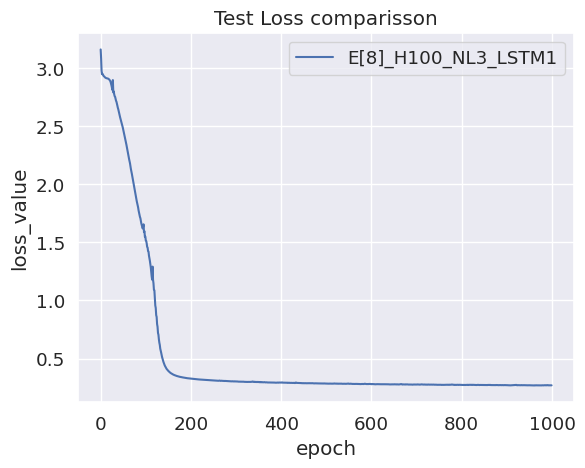

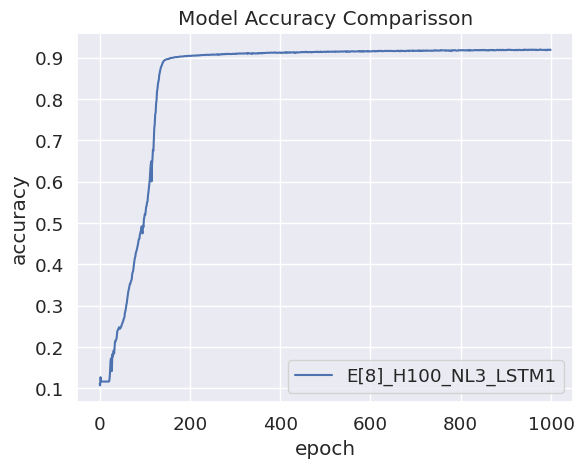

In [ ]:
#Comparison of lost from different models.
for loss_it in losses_models.values():
  plt.plot(loss_it)
plt.title('Test Loss comparisson')
plt.xlabel('epoch')
plt.ylabel('loss_value')
plt.legend(losses_models.keys())
plt.show()

for accuracy in accuracys_models.values():
  plt.plot(accuracy)
plt.title('Model Accuracy Comparisson')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(accuracys_models.keys())
plt.show()

In [ ]:
def find_key(plaintext, ciphertext):
    key = ""
    for i in range(len(plaintext)):
        shift = (ord(ciphertext[i]) - ord(plaintext[i])) % 26
        key += chr(shift + 65)  # Convert shift to uppercase letter
    return key


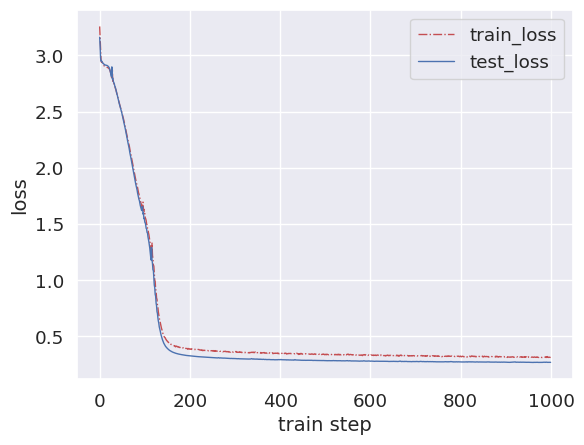

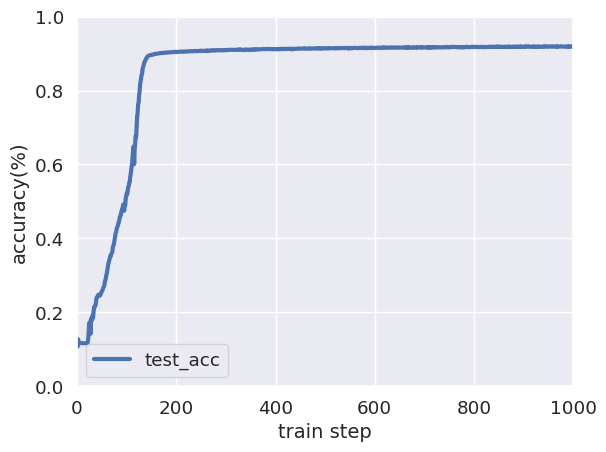

[0.11114063113927841, 0.10712500661611557, 0.12709376215934753, 0.11765625327825546, 0.11660937964916229, 0.11660937964916229, 0.11668750643730164, 0.11668750643730164, 0.11668750643730164, 0.11668750643730164, 0.11668750643730164, 0.11646875739097595, 0.11646875739097595, 0.11668750643730164, 0.11668750643730164, 0.11668750643730164, 0.11646875739097595, 0.11646875739097595, 0.11646875739097595, 0.11646875739097595, 0.11646875739097595, 0.11732812970876694, 0.12400000542402267, 0.1399843841791153, 0.16484375298023224, 0.17273437976837158, 0.16740626096725464, 0.14195312559604645, 0.18254688382148743, 0.1768437623977661, 0.18515625596046448, 0.1912500113248825, 0.18437500298023224, 0.19782812893390656, 0.21360938251018524, 0.21290625631809235, 0.2173437625169754, 0.21901562809944153, 0.22620312869548798, 0.23814064264297485, 0.24045313894748688, 0.24260938167572021, 0.24592188000679016, 0.24790626764297485, 0.2448125183582306, 0.24431250989437103, 0.24576564133167267, 0.248859390616416

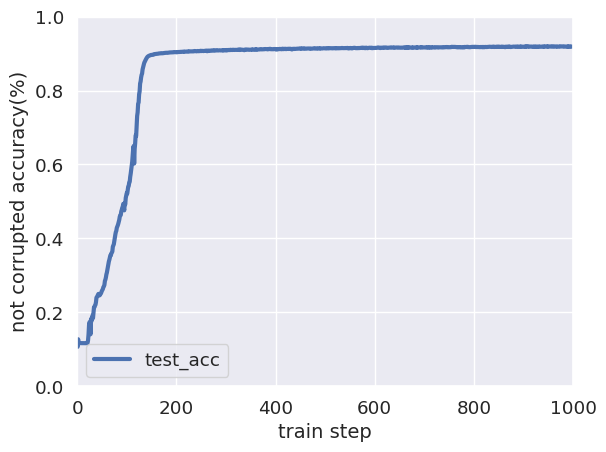

[0.11125504225492477, 0.10672136396169662, 0.1271229237318039, 0.11791162937879562, 0.1167062520980835, 0.1167062520980835, 0.11676022410392761, 0.11676022410392761, 0.11676022410392761, 0.11676022410392761, 0.11676022410392761, 0.116508349776268, 0.116508349776268, 0.11676022410392761, 0.11676022410392761, 0.11676022410392761, 0.116508349776268, 0.116508349776268, 0.116508349776268, 0.116508349776268, 0.116508349776268, 0.11733593046665192, 0.12408247590065002, 0.14005829393863678, 0.16529937088489532, 0.17346718907356262, 0.16832181811332703, 0.14066998660564423, 0.18197683990001678, 0.17625576257705688, 0.18508924543857574, 0.19126008450984955, 0.1842796504497528, 0.19762882590293884, 0.21364061534404755, 0.2138565182685852, 0.21871402859687805, 0.22038717567920685, 0.22767344117164612, 0.23988918960094452, 0.241886168718338, 0.24404506385326385, 0.24751727283000946, 0.2498740702867508, 0.24631190299987793, 0.24561025202274323, 0.24695956707000732, 0.25016191601753235, 0.25102546811

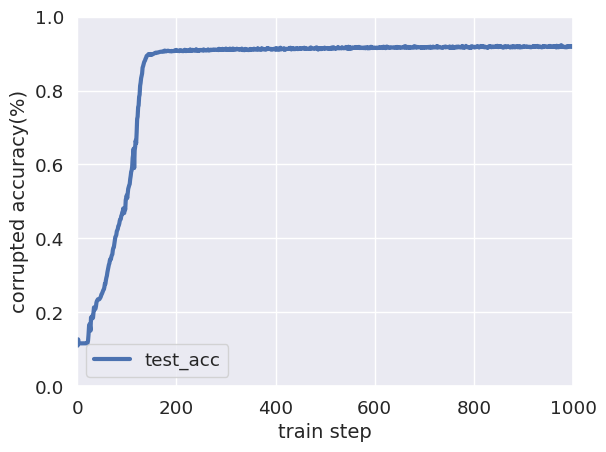

[0.1103849783539772, 0.1097908765077591, 0.12690113484859467, 0.11596958339214325, 0.11596958339214325, 0.11596958339214325, 0.11620722711086273, 0.11620722711086273, 0.11620722711086273, 0.11620722711086273, 0.11620722711086273, 0.11620722711086273, 0.11620722711086273, 0.11620722711086273, 0.11620722711086273, 0.11620722711086273, 0.11620722711086273, 0.11620722711086273, 0.11620722711086273, 0.11620722711086273, 0.11620722711086273, 0.1172766163945198, 0.12345532327890396, 0.13949619233608246, 0.16183459758758545, 0.16789448261260986, 0.16135931015014648, 0.15042775869369507, 0.1863117814064026, 0.18072718381881714, 0.18559886515140533, 0.19118346273899078, 0.18500475585460663, 0.19914448261260986, 0.21340304613113403, 0.20663022994995117, 0.20829372107982635, 0.20995722711086273, 0.2164923995733261, 0.22659219801425934, 0.23098859190940857, 0.23312737047672272, 0.2353849858045578, 0.23490969836711884, 0.23490969836711884, 0.23574143648147583, 0.23788022994995117, 0.2402566522359848

In [ ]:
plt.plot(loss_hist, '-.r', linewidth=1.0, label='train_loss')
plt.plot(test_loss_hist,'-b', linewidth=1.0, label='test_loss')
plt.xlabel('train step', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend()
plt.show()

plt.plot(acc_hist, linewidth=3.0, label='test_acc')
plt.xlabel('train step', fontsize=14)
plt.ylabel('accuracy(%)', fontsize=14)
plt.ylim([0, 1])
plt.xlim([0, num_epochs])
plt.legend()
plt.show()
print(acc_hist)

plt.plot(acc_non_corr_hist, linewidth=3.0, label='test_acc')
plt.xlabel('train step', fontsize=14)
plt.ylabel('not corrupted accuracy(%)', fontsize=14)
plt.ylim([0, 1])
plt.xlim([0, num_epochs])
plt.legend()
plt.show()
print(acc_non_corr_hist)

plt.plot(acc_corr_hist, linewidth=3.0, label='test_acc')
plt.xlabel('train step', fontsize=14)
plt.ylabel('corrupted accuracy(%)', fontsize=14)
plt.ylim([0, 1])
plt.xlim([0, num_epochs])
plt.legend()
plt.show()
print(acc_corr_hist)

decrypter_network = decrypter_network.cpu()
for idx_sample in range(0,10):
  # Inference over single training sequence
  letters_probs = decrypter_network(test[idx_sample][0].unsqueeze(0))
  # get index of letter with max probability
  _,maxprob_letters_idx = letters_probs.max(dim=2)
  ciphertext = decode_message(test[idx_sample][0],vocabulary)
  plaintext = decode_message(test[idx_sample][1],vocabulary)
  print('--------------------------------------')
  print(f'Original Message encrypted: {ciphertext}')
  #print(f'Encryption key:{find_key(plaintext, ciphertext)}')
  print(f'Message decrypted: {plaintext}')
  print(f'Prediction Message decrypted: {decode_message(maxprob_letters_idx[0],vocabulary)}')
  acc = (1.0*(maxprob_letters_idx[0]==test[idx_sample][1])).mean().item()
  print(f'Prediction Message Accuracy : {round(acc,2)}')

In [ ]:
#we've learned that the key is PYTORCH
ciphertext = decode_message(train[0][0],vocabulary)
plaintext = decode_message(train[0][1],vocabulary)
print('--------------------------------------')
print(f'Original Message encrypted: {ciphertext}')
print(f'Encryption key:{find_key(plaintext, ciphertext)}')
print(f'Message decrypted: {plaintext}')

--------------------------------------
Original Message encrypted: XJEQRNSIFXAKQTDPKCNYOTLBQFOLQYVY
Encryption key:PYTORCHPYTORCHPYTORCHPYTORCHPYTO
Message decrypted: ILLCALLTHEMTOMORROWWHENICOMEBACK
